In [1]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import style
style.use("default")
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from collections import Counter

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

pd.options.mode.chained_assignment = None

In [2]:
df = pd.read_csv("/Users/guillaumedenis/Programmation/Datasets/healthcare-dataset-stroke-data.csv")
print(df.info(), "\n")

# Valeurs manquantes
print(df.isnull().sum(), "\n")

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None 

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### Data Analysis

<AxesSubplot:xlabel='stroke', ylabel='percentage'>

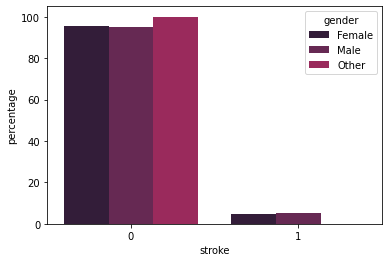

In [3]:
# Genre en fonction d'une stroke
# On met en pourcentage
df_gender = df.groupby(["gender"])["stroke"].value_counts(normalize = True).mul(100).rename("percentage").reset_index()

col_palette = sns.color_palette("rocket")
sns.barplot(x = "stroke", y = "percentage", hue = "gender", data = df_gender, palette = col_palette)


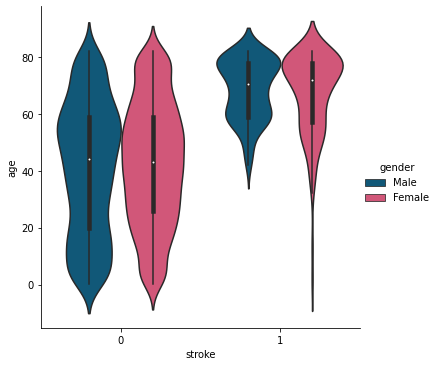

In [4]:
# Relation avec l'âge
sns.catplot(x = "stroke", y = "age", hue = "gender", data = df[df["gender"].isin(["Male","Female"])], kind = "violin", 
           palette = ["#005f89","#e54370"])


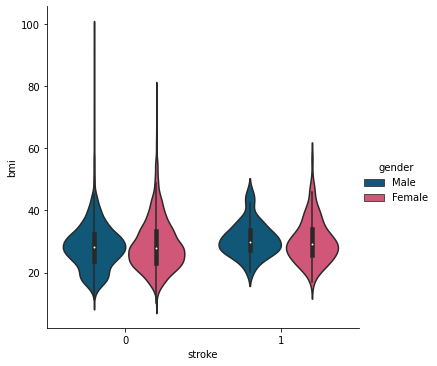

In [5]:
# Relation avec le BMI (en excluant les valeurs manquantes)
sns.catplot(x = "stroke", y = "bmi", hue = "gender", data = df[(df["bmi"].isnull()== False) & df["gender"].isin(["Male","Female"])], 
            kind = "violin", 
           palette = ["#005f89","#e54370"])


<AxesSubplot:xlabel='stroke', ylabel='percentage'>

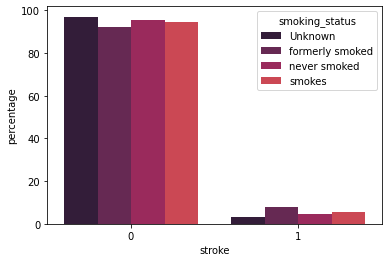

In [6]:
# Smoking status
smoke_perc = df.groupby(["smoking_status"])["stroke"].value_counts(normalize = True).mul(100).rename("percentage").reset_index()


sns.barplot(x = "stroke", y = "percentage", hue = "smoking_status", data = smoke_perc, palette = col_palette)


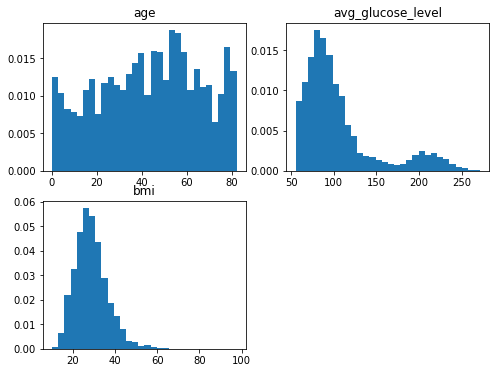

In [7]:
columns = df.select_dtypes("float64").columns


plt.figure(figsize = (8,6))

for i, column in enumerate(columns):
    plt.subplot(2, 2, i+1).set_title(column)
    plt.hist(df[column], density = True, bins = 30)

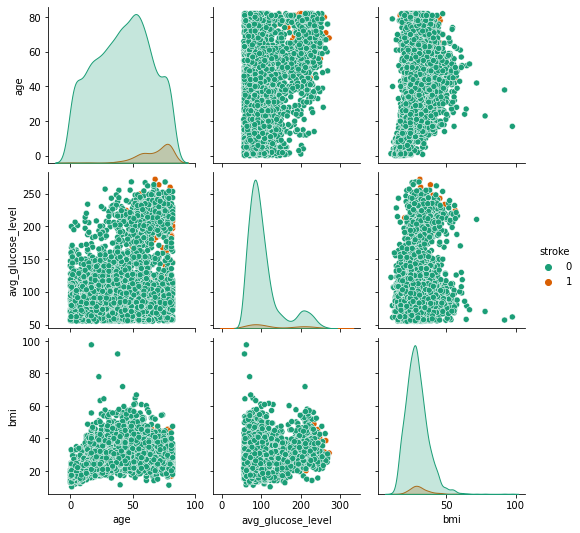

In [8]:
# sns.pairplot(df[columns], hue = "stroke", palette = "Dark2")
columns = ['age', 'avg_glucose_level', 'bmi', "stroke"]

sns.pairplot(df[columns], hue = 'stroke', palette = "Dark2")

### Data Cleaning

In [9]:
# On crée le training et testing datset

def onehot_encoder(data):
    
    df = data.copy()
    df.drop("id", axis = 1, inplace = True)
    df = df[df["gender"] != "Other"]
    X = df.drop("stroke", axis = 1)
    y = df["stroke"]
    
    
    # Testing and training dataset
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 100)
    
    
    # On replace les valeurs manquantes
    med = np.nanmedian(X_train["bmi"])
    
    
    X_train["bmi"].fillna(med, inplace = True)
    X_test["bmi"].fillna(med, inplace = True)
    
    
    # Normalization
    norm_col = ["age", "avg_glucose_level", "bmi"]
    scaler = preprocessing.StandardScaler().fit(X_train[norm_col])
    X_scaled_train = scaler.transform(X_train[norm_col])
    X_scaled_test = scaler.transform(X_test[norm_col])
    
    
    X_train[norm_col] = X_scaled_train
    X_test[norm_col] = X_scaled_test
    
    # Création de variables dummy
    dummy_col = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
    X_train = pd.get_dummies(X_train, columns = dummy_col)
    X_test = pd.get_dummies(X_test, columns = dummy_col)
    
    
    
    return X_train, X_test, y_train, y_test
    
    

In [10]:
X_train, X_test, y_train, y_test = onehot_encoder(df)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4087, 20)
(1022, 20)
(4087,)
(1022,)


### Modelisation

In [15]:
kernels = ["Polynomial", "RBF", "Sigmoid", "Linear"]

def getClassifier(ktype):
    if ktype == 0:
        # Polynomial kernal
        return SVC(kernel='poly', degree=8, gamma="auto")
    elif ktype == 1:
        # Radial Basis Function kernal
        return SVC(kernel='rbf', gamma="auto")
    elif ktype == 2:
        # Sigmoid kernal
        return SVC(kernel='sigmoid', gamma="auto")
    elif ktype == 3:
        # Linear kernal
        return SVC(kernel='linear', gamma="auto")
    
for i in range(4):
    svc_classifier = getClassifier(i)
    svc_classifier.fit(X_train, y_train)
    y_pred = svc_classifier.predict(X_test)
    print(kernels[i],":", round(accuracy_score(y_pred, y_test),6))
    print(confusion_matrix(y_pred, y_test))
    

Polynomial : 0.95499
[[976  46]
 [  0   0]]
RBF : 0.95499
[[976  46]
 [  0   0]]
Sigmoid : 0.945205
[[966  46]
 [ 10   0]]
Linear : 0.95499
[[976  46]
 [  0   0]]


In [23]:
print(grid.best_estimator_)
grid_predictions = grid.predict(X_test)
print(accuracy_score(grid_predictions, y_test))

print(confusion_matrix(grid_predictions, y_test))

SVC(C=0.1, gamma=1)
0.9549902152641878
[[976  46]
 [  0   0]]
